# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    """
    A function that reads the raw data contained in the txt file, parse them
    and puts them in three different fields of a h5 file : a field for
    timestamps, a field for latitudes, and a field for logitudes.
    """
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000000,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000000,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000000,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
"""we parse the txt file assuming it is located in the same directory as
the current Notebook"""

parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, *i.e* that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [3]:
# we open the h5 file that contains the data
import h5py
f = h5py.File('dataset.hdf5', 'r')

In [14]:
# we put the data into lists
timestamps = f['timestamps'] # array of numpy ints
latitudes = f['latitudes'] # list of numpy floats
longitudes = f['longitudes'] # list of numpy floats

# we test that the file is not corrupted
print("Timestamps    Latitudes    Longitudes\n")
for i in range(0, 10):
    print(str(timestamps[i]) + "    " + str(latitudes[i]) + "    " + str(longitudes[i]))

Timestamps    Latitudes    Longitudes

1504866207    0.375267    52.2639
1504866208    121.035    14.6517
1504866208    -61.2052    -27.2133
1504866209    101.691    3.05276
1504866209    12.3267    45.4386
1504866209    135.504    34.6802
1504866209    139.753    35.6544
1504866209    139.776    35.7133
1504866209    4.08333    48.3
1504866210    103.855    1.30046


In [20]:
dataset = list(zip(latitudes, longitudes)) # list of tuples (lat, lon)

# we check if the zip did it right
print("Latitudes    Longitudes\n")
for i in range(0, 10):
    print(str(dataset[i][0]) + "    " + str(dataset[i][1]))

Latitudes    Longitudes

0.375267    52.2639
121.035    14.6517
-61.2052    -27.2133
101.691    3.05276
12.3267    45.4386
135.504    34.6802
139.753    35.6544
139.776    35.7133
4.08333    48.3
103.855    1.30046


In [21]:
# we select a random sample of the points
import numpy as np
import matplotlib.pyplot as plt
import random
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

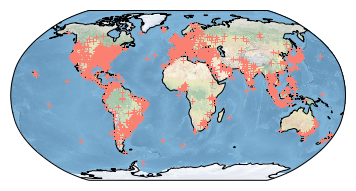

In [22]:
"""we plot the sample points on a map in order to check if the positions of
the points seem relevant with the positions of the continents"""

import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
plt.plot(sample_latitudes, sample_longitudes, '+', transform=ccrs.PlateCarree(), color='salmon')
plt.show()

## Computation of the Betas

First we create a dictionnary that maps an *id* (i.e. an int) two each tweet,
defined by its coordinates (i.e. a tuple of floats). From now on, we will 
manipulate point through their *id*, because it seems more convenient and efficient.

In [12]:
import numpy as np

id_to_coords = {i : point for i, point in enumerate(dataset)}

### Definition of the metric

Here we define a metric that is consistent with the data we deal with : the **Haversine distance**, which is basically the number of kilometers between two points located with their GPS coordinates.
We will use this metric to compute all the distances that are used during the project (including min and max distances between each pair of points, which have a direct incidence on the *betas*).

In [23]:
import math

def Haversine(point, neighbor):
    """
    The function takes two tuples (two points) and computes their Haversin distance
    """
    lat1 = point[0]
    lat2 = neighbor[0]
    lon1 = point[1]
    lon2 = neighbor[1]
    R=6371000                             
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
    return R*c/1000

In [29]:
"""we check whether the Haversine distance between two points (in kilometers)
seems to be ok"""

print("Distance between point 1 and point 2 : " + str(Haversine(dataset[0], dataset[1])) + " km")
print("Distance between point 1 and point 3 : " + str(Haversine(dataset[0], dataset[2])) + " km")
print("Distance between point 2 and point 3 : " + str(Haversine(dataset[1], dataset[2])) + " km")

Distance between point 1 and point 2 : 12648.7174267 km
Distance between point 1 and point 3 : 9483.09288633 km
Distance between point 2 and point 3 : 17720.5130311 km


### Min and max distances

Here we go through a kind of technical part. In a first trial, we used the *pdist* function from the spatial Scipy package which computes the pairwise distances between all points within a dataset. But this function ran out of memory because there was to many points (tweets) to handle in our case.

Then we thought we should not compute **all** the distances, because after all we were just interested in very special distances of dataset (*i.e.* the minimum and the maximum !). We thus chose to use more refined methods.

So we define here two methods that compute respectively the minimum distance and the maximum distance between each two points in our dataset. The code snippets that follow are strongly inspired from :
- https://stackoverflow.com/questions/5119644/identifying-points-with-the-smallest-euclidean-distance (for the Delaunay triangulation and the min distance)
- https://www.ics.uci.edu/~eppstein/161/python/diameter.py (for the Rotating Calipers and the max distance)

In [203]:
from scipy import spatial

def min_distance(dataset):
    """
    This function computes the distance between the two closest points of the dataset.
    It is based on the Delaunay triangulation (by definition the closest pair of
    points in a set define an edge in the Delaunay triangulation of this set). We 
    adapted a bit the original version (that relies on the Euclidean distance), to
    consider instead the Haversine distance
    """
    # set up the triangulation
    mesh = spatial.Delaunay(dataset)
    edges = np.vstack((mesh.vertices[:,:2], mesh.vertices[:,-2:]))
    points1 = mesh.points[edges[:,0]]
    points2 = mesh.points[edges[:,1]]
    dists = ([Haversine(p1, p2) for p1, p2 in zip(points1, points2)])
    idx = np.argmin(dists)
    i, j = edges[idx]
    return Haversine(dataset[i], dataset[j])

In [204]:
from __future__ import generators

def orientation(p,q,r):
    """
    Return positive number if p-q-r are clockwise, neg if ccw, zero if colinear.
    """
    return (q[1]-p[1])*(r[0]-p[0]) - (q[0]-p[0])*(r[1]-p[1])

def hulls(dataset):
    """
    Graham scan to find upper and lower convex hulls of a set of 2d points.
    """
    U = []
    L = []
    dataset.sort()
    for p in dataset:
        while len(U) > 1 and orientation(U[-2],U[-1],p) <= 0: U.pop()
        while len(L) > 1 and orientation(L[-2],L[-1],p) >= 0: L.pop()
        U.append(p)
        L.append(p)
    return U,L

def rotating_calipers(dataset):
    """
    Given a list of 2d points, finds all ways of sandwiching the points between
    two parallel lines that touch one point each, and yields the sequence of pairs of
    points touched by each pair of lines.
    """
    U,L = hulls(dataset)
    i = 0
    j = len(L) - 1
    while i < len(U) - 1 or j > 0:
        yield U[i],L[j]
        
        # if all the way through one of top or bottom, advance the other
        if i == len(U) - 1: j -= 1
        elif j == 0: i += 1
        
        # still points left on both lists, compare slopes of next hull edges
        elif (U[i+1][1]-U[i][1])*(L[j][0]-L[j-1][0]) > \
                (L[j][1]-L[j-1][1])*(U[i+1][0]-U[i][0]):
            i += 1
        else: j -= 1

def max_distance(dataset):
    """
    Given a list of 2d points, returns the pair that's farthest apart.
    The key is to use the method of rotating calipers, an algorithm design
    technique that can be used to solve optimization problems including
    finding the width or diameter of a set of points (that is what we want).
    """
    best_dist = 0
    for p1, p2 in rotating_calipers(dataset):
        dist = Haversine(p1, p2)
        if dist > best_dist:
            best_dist = dist
    return best_dist

In [205]:
max_dist = max_distance(dataset)

In [206]:
min_dist = min_distance(np.asarray(dataset))

In [207]:
print("Max distance : " + str(max_dist))
print("Minimum distance : " + str(min_dist))

Max distance : 18680.1424983
Minimum distance : 8.50586308516e-07


In [208]:
def compute_betas(max_dist, min_dist, eps):
    betas = []
    i_min = int(math.ceil(math.log(min_dist)/math.log(1+eps)))
    i_max = int(math.floor(math.log(max_dist)/math.log(1+eps)))
    for i in range(i_min, i_max+1):
        betas.append((1+eps)**i)
    return betas

In [210]:
betas = compute_betas(max_dist, min_dist, 2)
print('Minimum beta : ' + str(betas[0]))
print('Maximum beta : ' + str(betas[-1]))
print('Number of betas : ' + str(len(betas)))

Minimum beta : 1.88167642316e-06
Maximum beta : 6561
Number of betas : 21


# Basic static algorithm

### Static clustering

In [73]:
def build_cluster(center_id, beta, dataset_ids, clusters):
    center = id_to_coords[center_id]
    clusters[center_id] = center_id
    i = 0
    k = 0
    while True:
        if i >= len(dataset_ids):
            break      
        k += 1
        point_id = dataset_ids[i]
        if point_id != center_id:
            distance = Haversine(center, id_to_coords[point_id])
            if distance <= 2*beta:
                clusters[point_id] = (center_id)
                dataset_ids.remove(point_id)
            else:
                i += 1
        else:
            dataset_ids.remove(point_id)
    print(str(k) + ' points have been scanned ')
    print(str(len(dataset_ids)) +' points remain to be affected')
    print('')
    return dataset_ids, clusters

In [74]:
from copy import deepcopy

def build_beta_clustering(k, beta, dataset_ids):
    clusters = {point_id : -1 for point_id in dataset_ids}
    order = []
    d = deepcopy(dataset_ids)
    for i in range(0, k):
        if not d:
            break
        center_id = random.choice(d)
        order.append(center_id)
        d.remove(center_id)
        print('Building cluster ' + str(i+1) + ' whose center is ' + str(center_id))
        d, clusters = build_cluster(center_id, beta, d, clusters)
    return clusters, order

In [75]:
def build_whole_clustering(k, betas, dataset_ids):
    clustering, ordering = {}, {}
    for beta in betas:
        print('Computing for beta = ' + str(beta))
        print('')
        clusters, order  = build_beta_clustering(k, beta, dataset_ids)
        ordering[beta] = order
        clustering[beta] = clusters
        print('##########################################')
    return clustering, ordering

In [78]:
beta_test = 1500
clustering, ordering = build_whole_clustering(11, [beta_test], random.sample(list(range(0, 1000000)), 20000))
print(ordering)

Computing for beta = 1500

Building cluster 1 whose center is 262512
19999 points have been scanned 
17337 points remain to be affected

Building cluster 2 whose center is 527913
17336 points have been scanned 
11014 points remain to be affected

Building cluster 3 whose center is 674311
11013 points have been scanned 
9064 points remain to be affected

Building cluster 4 whose center is 559407
9063 points have been scanned 
6350 points remain to be affected

Building cluster 5 whose center is 71093
6349 points have been scanned 
6148 points remain to be affected

Building cluster 6 whose center is 183576
6147 points have been scanned 
4449 points remain to be affected

Building cluster 7 whose center is 316554
4448 points have been scanned 
1909 points remain to be affected

Building cluster 8 whose center is 8678
1908 points have been scanned 
483 points remain to be affected

Building cluster 9 whose center is 82993
482 points have been scanned 
329 points remain to be affected

Bui

In [79]:
from collections import defaultdict

def plot_cluster_sizes(clusters):
    counts = defaultdict(int)
    for point_id, center_id in clusters.items():
        counts[center_id] += 1
    plt.bar(np.arange(len(counts.keys())), counts.values())
    plt.ylabel('Number of points')
    plt.xlabel('Clusters')
    plt.show()

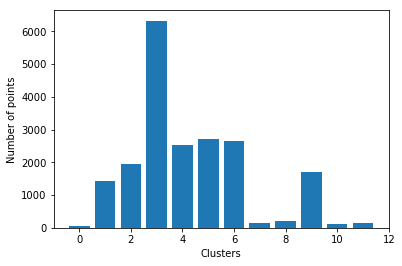

In [80]:
plot_cluster_sizes(clustering[beta_test])

In [81]:
def plot_clusters_on_map(clusters, order):
    centers_ids = order
    col = ['salmon', 'plum', 'lime', 'lavender', 'goldenrod', 'aquamarine', 'orangered', 'darkgreen', 'sienna', 'navy', 'crimson', 'yellow' ] 
    fig = plt.figure(figsize=(8, 10), dpi=100)
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    for center_id in centers_ids:
        affected_points = [point_id for point_id, c in clusters.items() if c == center_id]
        affected_points = random.sample(affected_points, min(200, len(affected_points)))
        latitudes = [id_to_coords[i][0] for i in affected_points]
        longitudes = [id_to_coords[i][1] for i in affected_points]
        c = col[centers_ids.index(center_id)]
        plt.plot(latitudes, longitudes, '+', transform=ccrs.PlateCarree(), color=c)
        center_latitude = id_to_coords[center_id][0]
        center_longitude = id_to_coords[center_id][1]
        plt.plot(center_latitude, center_longitude, 'o', transform=ccrs.PlateCarree(), color=c, markeredgewidth=1., markeredgecolor='black')
    plt.title('Cluster samples (round=centers; cross=random points)')
    plt.show()

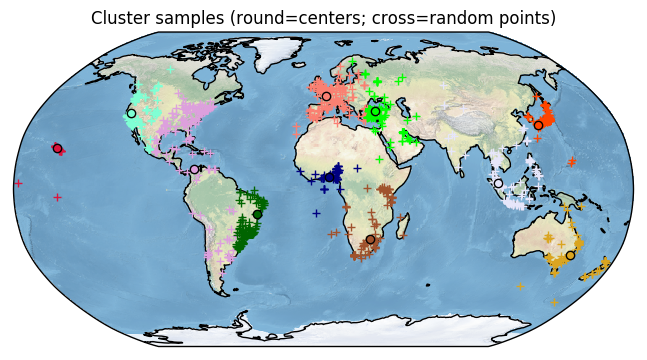

In [82]:
plot_clusters_on_map(clustering[beta_test], ordering[beta_test])

### Dynamic clustering

#### Insertion

In [110]:
def insertion(k, point_id, clustering, ordering):
    print('New point to be added : ' + str(point_id))
    for (beta, beta_clustering) in clustering.items():
        print('Inserting in the clustering of beta = ' + str(beta))
        if point_id in beta_clustering.keys():
            print('This point already exists : no changes')
            break
        centers_ids = ordering[beta]
        found = 0
        for center_id in centers_ids:
            center = id_to_coords[center_id]
            point = id_to_coords[point_id]
            if Haversine(center, point) <= 2*beta:
                print('This point belongs to the cluster of point ' + str(center_id))
                print('')
                beta_clustering[point_id] = center_id
                found = 1
                break
        if found == 0:
            if len(centers_ids) < k:
                beta_clustering[point_id] = point_id
                centers_ids.append(point_id)
                print('This point will form a new cluster')
                print('')
            else:
                print('This point is not yet affected to any cluster')
                print('')
                beta_clustering[point_id] = -1
    return clustering, ordering

In [114]:
beta_test = 1000
k = 100
dataset_ids = list(range(0, 100)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    clustering, ordering = insertion(k, new_point, clustering, ordering)
    print('Length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('Number of clusters : ' + str(n_clusters))
    center_id = clustering[beta_test][new_point]
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('Distance between the new point and its center : ' + str(Haversine(center, new_point)))
    print('')


Computing for beta = 1000

Building cluster 1 whose center is 58
99 points have been scanned 
87 points remain to be affected

Building cluster 2 whose center is 69
86 points have been scanned 
79 points remain to be affected

Building cluster 3 whose center is 93
78 points have been scanned 
54 points remain to be affected

Building cluster 4 whose center is 83
53 points have been scanned 
47 points remain to be affected

Building cluster 5 whose center is 50
46 points have been scanned 
42 points remain to be affected

Building cluster 6 whose center is 86
41 points have been scanned 
37 points remain to be affected

Building cluster 7 whose center is 99
36 points have been scanned 
23 points remain to be affected

Building cluster 8 whose center is 16
22 points have been scanned 
13 points remain to be affected

Building cluster 9 whose center is 30
12 points have been scanned 
10 points remain to be affected

Building cluster 10 whose center is 47
9 points have been scanned 
7 poin

In [115]:
beta_test = 1000
k = 5
dataset_ids = list(range(0, 100)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    clustering, ordering = insertion(k, new_point, clustering, ordering)
    print('Length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('Number of clusters : ' + str(n_clusters))
    center_id = clustering[beta_test][new_point]
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('Distance between the new point and its center : ' + str(Haversine(center, new_point)))
    print('')


Computing for beta = 1000

Building cluster 1 whose center is 19
99 points have been scanned 
80 points remain to be affected

Building cluster 2 whose center is 87
79 points have been scanned 
72 points remain to be affected

Building cluster 3 whose center is 95
71 points have been scanned 
62 points remain to be affected

Building cluster 4 whose center is 61
61 points have been scanned 
50 points remain to be affected

Building cluster 5 whose center is 4
49 points have been scanned 
46 points remain to be affected

##########################################
New point to be added : 2921
Inserting in the clustering of beta = 1000
This point belongs to the cluster of point 61

Length of the new dataset : 101
Number of clusters : 5
Distance between the new point and its center : 557.030534048

New point to be added : 721087
Inserting in the clustering of beta = 1000
This point belongs to the cluster of point 4

Length of the new dataset : 102
Number of clusters : 5
Distance between th

#### Deletion

In [116]:
def deletion(point_id, clustering, ordering):
    print('New point to be deleted : ' + str(point_id))
    for (beta, beta_clustering) in clustering.items():
        print('Deleting in the clustering of beta = ' + str(beta))
        if point_id not in beta_clustering.keys():
            print('This point does not exist : no changes')
            break
        beta_ordering = ordering[beta]
        if point_id not in beta_ordering:
            print('This point was not a center, the deletion does not affect the whole clustering')
            del beta_clustering[point_id]
        else:
            print('This point is a center : reclustering all the clusters created after it')
            del beta_clustering[point_id]
            
            i = beta_ordering.index(point_id)
            centers_to_recluster = beta_ordering[i:]
            beta_ordering = beta_ordering[:i]
            n_to_recluster = len(centers_to_recluster)
            centers_to_recluster.append(-1)
            points_to_recluster = [p for p, c in beta_clustering.items() if c in centers_to_recluster]
            
            sub_clusters, sub_order = build_beta_clustering(n_to_recluster, beta, points_to_recluster)
            beta_clustering, beta_ordering = merge(beta_clustering, beta_ordering, sub_clusters, sub_order)    
    return clustering, ordering

def merge(clusters, order, sub_clusters, sub_order):
    order = order + sub_order
    for point_id, center_id in sub_clusters.items():
        clusters[point_id] = center_id
    return clusters, order
    

In [117]:
beta_test = 1500
k = 10
dataset_ids = list(range(0, 1000)) 
clustering, ordering = build_whole_clustering(k, [beta_test], dataset_ids)

points_to_delete = random.sample(dataset_ids, 1000)

for point_id in points_to_delete:
    
    print('point to be deleted : ' + str(point_id))
    clustering, ordering = deletion(point_id, clustering, ordering)
    print('length of the new dataset : ' + str(len(clustering[beta_test].values())))
    n_clusters = len(ordering[beta_test])
    print('number of clusters : ' + str(n_clusters))
    print('')


Computing for beta = 1500

Building cluster 1 whose center is 280
999 points have been scanned 
852 points remain to be affected

Building cluster 2 whose center is 761
851 points have been scanned 
618 points remain to be affected

Building cluster 3 whose center is 964
617 points have been scanned 
448 points remain to be affected

Building cluster 4 whose center is 866
447 points have been scanned 
393 points remain to be affected

Building cluster 5 whose center is 708
392 points have been scanned 
215 points remain to be affected

Building cluster 6 whose center is 53
214 points have been scanned 
97 points remain to be affected

Building cluster 7 whose center is 282
96 points have been scanned 
80 points remain to be affected

Building cluster 8 whose center is 648
79 points have been scanned 
65 points remain to be affected

Building cluster 9 whose center is 633
64 points have been scanned 
51 points remain to be affected

Building cluster 10 whose center is 307
50 points have

#### Dynamic clustering

In [128]:
def generate_random_operations(max_id, length):
    operations = []
    for _ in range(0, length):
        point_id = random.choice(list(range(0, max_id)))
        operation = random.choice(['+', '-'])
        operations.append((point_id, operation))
    return operations

In [129]:
op = generate_random_operations(1000000, 10)
op

[(677160, '-'),
 (95315, '+'),
 (634240, '+'),
 (255529, '+'),
 (623647, '-'),
 (815372, '+'),
 (320150, '-'),
 (490476, '-'),
 (337694, '-'),
 (631577, '+')]

In [153]:
def dynamic_clustering(operations, initial_dataset, betas, k):
    clusterings, orderings = [], []
    clustering, ordering = build_whole_clustering(k, betas, initial_dataset)
    clusterings.append(clustering)
    orderings.append(ordering)
    for point_id, operation in operations:
        if operation == '+':
            clustering, ordering = insertion(k, point_id, clustering, ordering)
        else:
            clustering, ordering = deletion(point_id, clustering, ordering)
        clusterings.append(clustering)
        orderings.append(ordering)
    return clusterings, orderings

In [154]:
initial_dataset = random.sample(list(range(0, 1000000)), 100)
operations = generate_random_operations(1000000, 10)
betas = [1000, 1500]
k = 8
clusterings, orderings = dynamic_clustering(operations, initial_dataset, betas, k)

Computing for beta = 1000

Building cluster 1 whose center is 748864
99 points have been scanned 
77 points remain to be affected

Building cluster 2 whose center is 422854
76 points have been scanned 
62 points remain to be affected

Building cluster 3 whose center is 643157
61 points have been scanned 
49 points remain to be affected

Building cluster 4 whose center is 180401
48 points have been scanned 
41 points remain to be affected

Building cluster 5 whose center is 775052
40 points have been scanned 
33 points remain to be affected

Building cluster 6 whose center is 529746
32 points have been scanned 
19 points remain to be affected

Building cluster 7 whose center is 533299
18 points have been scanned 
13 points remain to be affected

Building cluster 8 whose center is 584958
12 points have been scanned 
12 points remain to be affected

##########################################
Computing for beta = 1500

Building cluster 1 whose center is 659119
99 points have been scanned 


Computing for beta = 1500

Building cluster 1 whose center is 863398
99 points have been scanned 
76 points remain to be affected

Building cluster 2 whose center is 717539
75 points have been scanned 
46 points remain to be affected

Building cluster 3 whose center is 926653
45 points have been scanned 
31 points remain to be affected

Building cluster 4 whose center is 283360
30 points have been scanned 
24 points remain to be affected

Building cluster 5 whose center is 526940
23 points have been scanned 
15 points remain to be affected

Building cluster 6 whose center is 757072
14 points have been scanned 
11 points remain to be affected

Building cluster 7 whose center is 118291
10 points have been scanned 
6 points remain to be affected

Building cluster 8 whose center is 900717
5 points have been scanned 
5 points remain to be affected

##########################################
New point to be deleted : 693147
Deleting in the clustering of beta = 1500
This point does not exist 

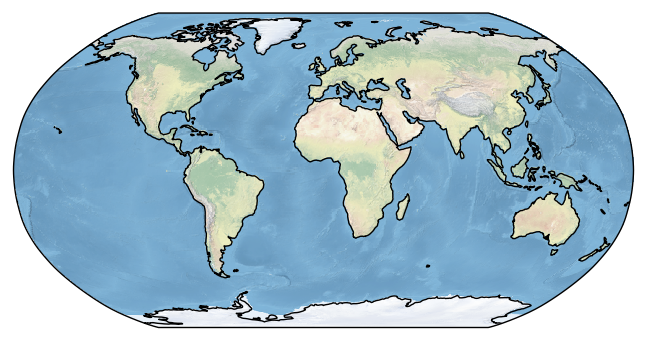

In [159]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

beta_test = 1500
initial_dataset = random.sample(list(range(0, 1000000)), 100)
operations = generate_random_operations(1000000, 20)
betas = [beta_test]
k = 8

clusterings, orderings = dynamic_clustering(operations, initial_dataset, betas, k)

col = ['salmon', 'plum', 'lime', 'lavender', 'goldenrod', 'aquamarine', 'orangered', 'darkgreen', 'sienna', 'navy', 'crimson', 'yellow' ] 
fig = plt.figure(figsize=(8, 10), dpi=100)
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
line, = ax.plot([], [])

def animate(i):
    global clusterings, orderings, beta_test, col, id_to_coords

    if i <= 20:
        clustering = clusterings[i]
        ordering = orderings[i]
        clusters = clustering[beta_test]
        centers_ids = ordering[beta_test]
        for center_id in centers_ids:
            affected_points = [point_id for point_id, c in clusters.items() if c == center_id]
            latitudes = [id_to_coords[i][0] for i in affected_points]
            longitudes = [id_to_coords[i][1] for i in affected_points]
            c = col[centers_ids.index(center_id)]
            center_latitude = id_to_coords[center_id][0]
            center_longitude = id_to_coords[center_id][1]
            line.set_data(latitudes+center_latitude, longitudes+center_longitude)
    return (line,)
        
def init():
    line.set_data([], [])
    return (line,)


anim = animation.FuncAnimation(fig, animate, init_func=init, interval=50, blit=True)

HTML(anim.to_html5_video())